In [76]:
#!/usr/bin/env python
# coding: utf-8

# In[253]:


# for nice display
get_ipython().run_line_magic('matplotlib', 'notebook')

# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import time
import os
import cv2

class Player():
    def __init__(self,shape,brain):
        # physics variables
        self.a_y = -100
        self.v_y = 20
        self.y = 50
        self.x = 30
        self.jump_x = 20
        self.alive = True
        # nural network creation
        # weights
        self.shape = shape
        self.brain = brain
        # layers
        self.layers = []
        for i in range(len(shape)):
            self.layers.append(np.ones(self.shape[i]))

    def randomizeBrain(self):
        self.brain = []
        for i in range(len(self.shape)-1):
            self.brain.append((np.random.rand(self.shape[i+1],self.shape[i])*2)-1)

    def act(self,p_b,p_t,p_d):
        self.in_vec = np.array([p_b,p_t,p_d,self.y,self.v_y])
        #self.in_vec /= 10
        self.layers[0] = self.in_vec
        for i, w in enumerate(self.brain):
            self.layers[i+1] = np.dot(self.layers[i],w.T)

            self.layers[i+1] = np.tanh(self.layers[i+1])
            #self.layers[i+1] = 1 / (1 + np.exp(self.layers[i+1]))
        if self.layers[-1][0] > 0.5:
            if self.x - self.jump_x >= 10:
                self.v_y = 40
                self.jump_x = self.x

    def isDead(self,p_b,p_t,p_d):
        if self.alive == False:
            return
        if self.alive:
            if self.y >= 94 or self.y <= 0:
                self.a_y = 0
                self.v_y = 0
                self.alive = False
            elif p_d < 0:
                self.alive = True
            elif p_d < 17:
                if self.y+5 >= p_t or self.y <= p_b:
                    self.a_y = 0
                    self.v_y = 0
                    self.alive = False
            else:
                self.alive = True

    def mutate(self,rate,n):
        mutants = []
        for i in range(n-1):
            new_brain = []
            for j in range(len(self.shape)-1):
                new_brain.append(self.brain[j] + (np.random.rand(self.shape[j+1],self.shape[j])*rate) - rate/2)
            mutants.append(Player(self.shape,new_brain))
        mutants.append(Player(self.shape,self.brain))
        return mutants

class Game():
    def __init__(self, N, shape, rate, mute_precent):
        self.birds = []
        self.players = []

        self.game(N, shape, rate, mute_precent)


    def birdDrawFirst(self, x, y, image, ax=None, zoom=1):
        for x0, y0 in np.array([x,y]).T[:30]:
            self.birds.append(ax.imshow(image, interpolation='nearest', extent=[x0,x0+(17*zoom),y0,y0+(12*zoom)]))

    def birdMove(self, x, y, image, ax, zoom=1):
        for i in self.birds:
            ax.images.remove(i)

        for i, (x0, y0) in enumerate(zip(x,y)):
            if i >= 30:
                break
            self.birds[i] = ax.imshow(image, interpolation='nearest', extent=[x0,x0+(17*zoom),y0,y0+(12*zoom)])
    def game(self, N, shape, rate, mute_precent):
        tps = 50
        self.players = []
        for i in range(N):
            brain = []
            for j in range(len(shape)-1):
                brain.append((np.random.rand(shape[j+1],shape[j])*2)-1)
            p = Player(shape,np.zeros(shape))
            p.randomizeBrain()
            self.players.append(p)
            
        self.players = np.array(self.players)
        fig, (ax, nn) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]})
        fig.set_size_inches(8,6)
        gen = 0
        bg_img = plt.imread(r'images/bg.png')
        while True:
            # physics variables
            t = 1/tps
            p_x = 0
            p_t = np.random.rand()*60 + 30
            p_b = p_t - 20
            p_t_coords = []
            x = 0
            
            birds_x = np.full(N,30)
            birds_y = np.full(N,50)
            while True:
                p_x += 80
                p_t = np.random.rand()*60 + 30
                p_t_coords.append(p_t)
                p_b = p_t - 20
                for i in range(80):
                    for ind, p in enumerate(self.players):
                        p.isDead(p_b,p_t,p_x-p.x)
                        if p.alive:
                            p.x += 1
                            p.v_y += p.a_y*t
                            p.y += p.v_y*t + p.a_y*t**2
                            p.act(p.y-p_b,p.y-p_t,p_x-p.x)
                            birds_x[ind] = p.x
                            birds_y[ind] = p.y
                for ind, p in enumerate(self.players):
                    if p.alive:
                        break
                else:
                    best = self.players[np.argsort(birds_x)[-1]]
                    self.best = best
                    nn.clear()
                    nn.set_xlim(-0.2,0.9)
                    nn.set_ylim(0,1.8)

                    diff = 1.6 / np.array(shape).max()
                    coords = []
                    layers = []
                    segs = []
                    widths = []
                    colors = []
                    for i,l in enumerate(shape):
                        layer = []
                        for h in np.arange(0,(diff*l),diff):
                            layer.append([1/len(shape)*i,h+(2-diff*l)/2])
                            coords.append([1/len(shape)*i,h+(2-diff*l)/2])

                        layers.append(layer)
                    coords = np.array(coords)
                    for i in range(len(shape)-1):
                         for j, n in enumerate(layers[i+1]):
                                for k, c in enumerate(layers[i]):
                                    segs.append([c,n])
                                    widths.append(abs(np.array(best.brain)[i][j,k]))
                                    if np.array(best.brain)[i][j,k] > 0:
                                        colors.append([0,0.2,1])
                                    else:
                                        colors.append([1,0.2,0])
                    lc = LineCollection(segs,linewidths=widths,colors=colors)
                    nn.add_collection(lc)
                    nn.scatter(coords[:,0],coords[:,1],s=100,c="w",edgecolors="black",zorder=1000)
                    nn.set_title("best neural network")

                    parents = self.players[np.argsort(birds_x)[-int(N/(100/mute_precent)):]]
                    next_gen = np.array([])
                    for p in parents:
                        next_gen = np.hstack((next_gen, np.array(p.mutate(rate,int(100/mute_precent)))))
                    self.players = next_gen
                    break
            # self.birds
            ax.clear()
            self.bg = ax.imshow(bg_img, interpolation='none', extent=[0,56.25,100,0])

            ax.set_ylim(0,100)
            
            birds_img = plt.imread(os.path.abspath(r'images/bird.png'))
            
            p_t_img = plt.imread(os.path.abspath(r'images/pt.png'))
            p_b_img = plt.imread(os.path.abspath(r'images/pb.png'))
            p_t_img = plt.imread(os.path.abspath(r'images/pt.png'))
            p_b_img = plt.imread(os.path.abspath(r'images/pb.png'))
            self.p_b_s = ax.imshow(p_b_img, extent = [p_x-10, p_x, p_b-100, p_b])
            self.p_t_s = ax.imshow(p_t_img, extent = [p_x-10, p_x, p_t, p_t+100])
            self.bird = ax.imshow(birds_img, interpolation='nearest', extent=[30,30.5,50,56])
            gen += 1
            ax.set_title("generation: " + str(gen))
            p_t_ind = -1
            bird_x = 30
            bird_y = 50
            self.best.a_y = -100
            self.best.v_y = 20
            self.best.y = 50
            self.best.x = 30
            self.best.jump_x = 20
            self.best.alive = True
            p_x = 0
            while True:
                p_t_ind += 1
                p_x += 80
                p_t = p_t_coords[p_t_ind]
                p_b = p_t - 20
                self.p_b_s.set_extent([p_x-10, p_x, p_b-100, p_b])
                self.p_t_s.set_extent([p_x-10, p_x, p_t, p_t+100])
                for j in range(20):
                    for i in range(4):
                        self.best.isDead(p_b,p_t,p_x-p.x)
                        if self.best.alive:
                            self.best.x += 1
                            self.best.v_y += self.best.a_y*t
                            self.best.y += self.best.v_y*t + self.best.a_y*t**2
                            self.best.act(self.best.y-p_b,self.best.y-p_t,p_x-self.best.x)
                            bird_x = self.best.x
                            bird_y = self.best.y    
                    x = self.best.x - 30
                    ax.set_xlim(x,x+60)
                    self.bg.set_extent([x,x+60,0,100])
                    self.bird.set_extent([self.best.x,self.best.x+8.5,self.best.y,self.best.y+6])
                    fig.canvas.draw()
                    time.sleep(t)
                if not self.best.alive:
                    break

<IPython.core.display.Javascript object>


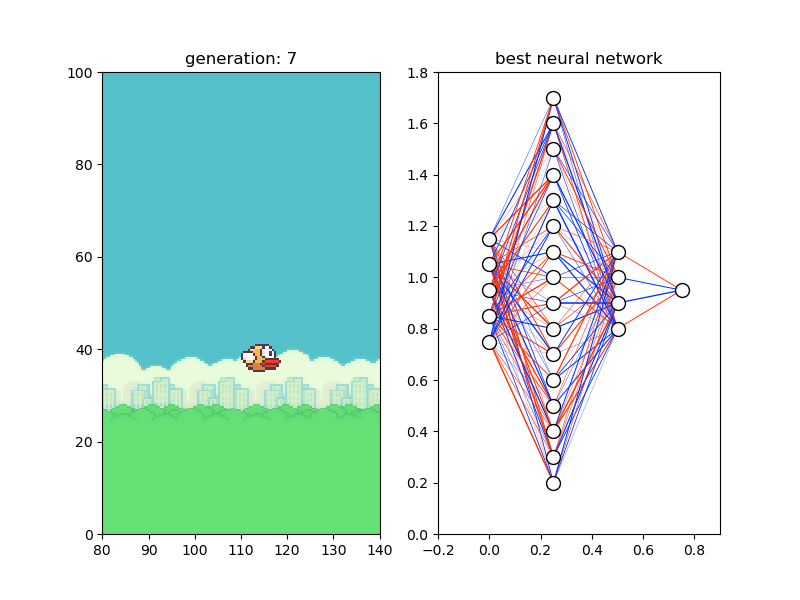

KeyboardInterrupt: 

In [77]:
N = 400  # player num    

shape = [5,16,4,1]

mutation_precentage = 5

learning_rate = 0.2

plt.show()
Game(N, shape, learning_rate, mutation_precentage)